# Import packages

In [1]:
import pandas as pd
from scipy.stats import ttest_rel

import matplotlib.pyplot as plt
import ptitprince as pt
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import auc, roc_curve, RocCurveDisplay, r2_score,\
    mean_absolute_error, mean_squared_error, recall_score, accuracy_score, f1_score, \
    precision_score, balanced_accuracy_score, roc_auc_score

import seaborn as sns

# Custom functions

In [2]:
from pickle_managment import load_pickle
from model_evaluation import delongs_test

# Regression

## Load pickles

In [3]:
regression_X_train = load_pickle(
    r'model_outputs\rf_regressor\regression_X_train.pkl')
regression_y_train = load_pickle(
    r'model_outputs\rf_regressor\regression_y_train.pkl')
regression_X_test = load_pickle(
    r'model_outputs\rf_regressor\regression_X_test.pkl')
regression_y_test = load_pickle(
    r'model_outputs\rf_regressor\regression_y_test.pkl')

best_rf_regressor = load_pickle(r'model_pickles\best_rf_regressor.pkl')
best_svm_regressor = load_pickle(r'model_pickles\best_svm_regressor.pkl')

In [4]:
y_pred_rf_train = best_rf_regressor.predict(regression_X_train)
y_pred_rf_test = best_rf_regressor.predict(regression_X_test)

y_pred_svm_train = best_svm_regressor.predict(regression_X_train)
y_pred_svm_test = best_svm_regressor.predict(regression_X_test)

In [5]:
rf_residual_train = regression_y_train - y_pred_rf_train
rf_residual_test = regression_y_test - y_pred_rf_test

rf_residual_train = rf_residual_train.reset_index(drop=True)
rf_residual_test = rf_residual_test.reset_index(drop=True)

In [6]:
#Calculate residuals
svm_residual_train = regression_y_train - y_pred_svm_train
svm_residual_test = regression_y_test - y_pred_svm_test

svm_residual_train = svm_residual_train.reset_index(drop=True)
svm_residual_test = svm_residual_test.reset_index(drop=True)

## p-values
F-stat will be hard to calculate since the number of parameters in the RF
regressor is tricky to determine. Instead, a student t-test will be
performed to compare the errors to check whether the 2 regressors'
performances are significantly different.

### Train set

In [7]:
t_statistic, p_value = ttest_rel(svm_residual_train, rf_residual_train)

print('p-value between 2 models on the train set:', p_value)

p-value between 2 models on the train set: 0.3201556837661093


### Test set

In [8]:
t_statistic, p_value = ttest_rel(svm_residual_test, rf_residual_test)

print('p-value between 2 models on the test set:', p_value)

p-value between 2 models on the test set: 0.05993440369319733


## Both regressors' residuals on train set

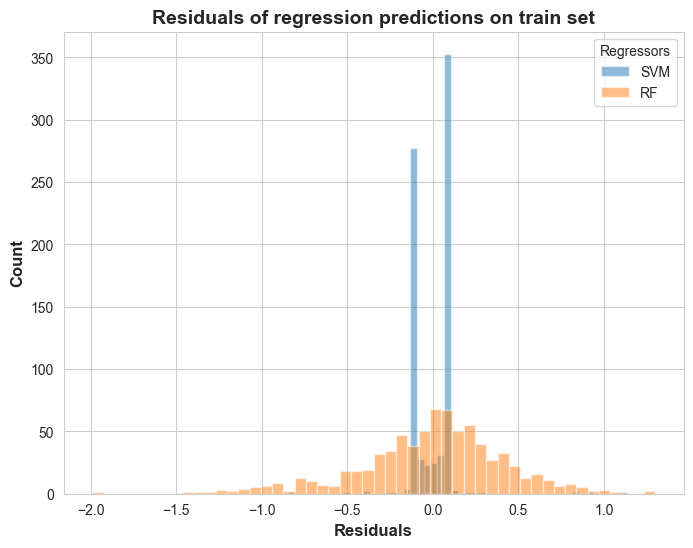

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))

plt.hist(svm_residual_train, bins=50, alpha=0.5, label='SVM')
plt.hist(rf_residual_train, bins=50, alpha=0.5, label='RF')

plt.xlabel('Residuals', weight='bold', fontsize=12)
plt.ylabel('Count', weight='bold', fontsize=12)
plt.title('Residuals of regression predictions on train set', weight='bold',
          fontsize=14)
plt.legend(title='Regressors')

plt.savefig(
    r'model_outputs\model_comparisions\svm_rf_train_residuals.png',
    dpi=600,
    bbox_inches='tight'
)

plt.show()

In [10]:
melted_df = pd.concat([svm_residual_train, rf_residual_train], axis=0,
                      keys=['svm', 'rf'])
melted_df = melted_df.reset_index()
melted_df.columns = ['regressor', 'index', 'residual']  # Rename columns

# Drop the 'index' column if not needed
melted_df = melted_df.drop(columns=['index'])
melted_df

,regressor,residual
0,svm,0.099902
1,svm,-0.100066
2,svm,-0.100411
3,svm,-0.099724
4,svm,0.099666
...,...,...
1507,rf,-0.857058
1508,rf,-0.025219
1509,rf,-0.182285
1510,rf,-0.226449


## Both regressors' residuals on test set

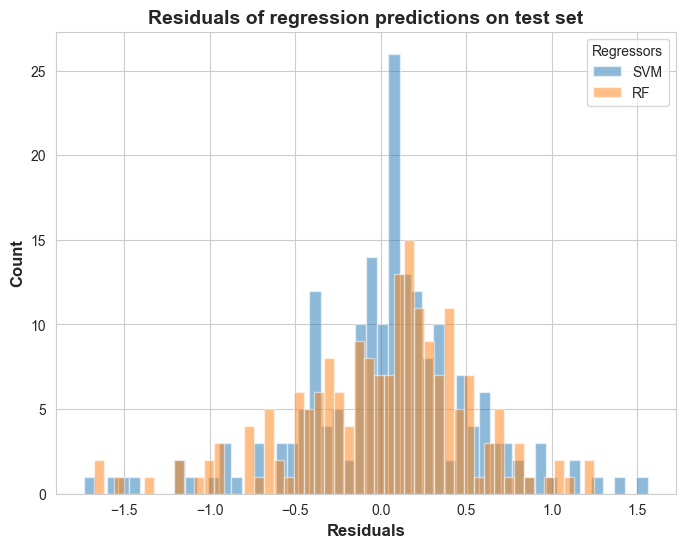

In [11]:
fig, ax = plt.subplots(figsize=(8, 6))

plt.hist(svm_residual_test, bins=50, alpha=0.5, label='SVM')
plt.hist(rf_residual_test, bins=50, alpha=0.5, label='RF')

plt.xlabel('Residuals', weight='bold', fontsize=12)
plt.ylabel('Count', weight='bold', fontsize=12)
plt.title('Residuals of regression predictions on test set', weight='bold',
          fontsize=14)
plt.legend(title='Regressors')

plt.savefig(
    r'model_outputs\model_comparisions\svm_rf_test_residuals.png',
    dpi=600,
    bbox_inches='tight'
)

plt.show()

## Compare side by side

In [14]:
# Concatenate the Series along the rows
regressors_compare_df = pd.concat(
    [svm_residual_train, svm_residual_test, rf_residual_train,
     rf_residual_test], axis=0, ignore_index=True)

# Create a list to store the original series names
series_names = ['svm_residual_train'] * len(svm_residual_train) + [
    'svm_residual_test'] * len(svm_residual_test) + [
                   'rf_residual_train'] * len(rf_residual_train) + [
                   'rf_residual_test'] * len(rf_residual_test)

# Create DataFrame with 'value', 'source', and 'series_name' columns
regressors_compare_df = pd.DataFrame(
    {'Residuals': regressors_compare_df, 'source': series_names})

# Split 'source' column into 'datasets' and 'regressors' columns
regressors_compare_df[['Regressors', 'intermediate_str']] =regressors_compare_df['source'].str.split('_', n=1,
                                          expand=True)
regressors_compare_df[['useless', 'Datasets']] = regressors_compare_df[
    'intermediate_str'].str.split('_', n=1,
                                  expand=True)
# Drop the original 'source' column
regressors_compare_df = regressors_compare_df.drop(
    columns=['source', 'intermediate_str', 'useless'])
regressors_compare_df = regressors_compare_df[['Regressors', 'Datasets',
                                               'Residuals']]
regressors_compare_df

,Regressors,Datasets,Residuals
0,svm,train,0.099902
1,svm,train,-0.100066
2,svm,train,-0.100411
3,svm,train,-0.099724
4,svm,train,0.099666
...,...,...,...
1885,rf,test,0.615361
1886,rf,test,0.392079
1887,rf,test,-0.982204
1888,rf,test,-0.301559


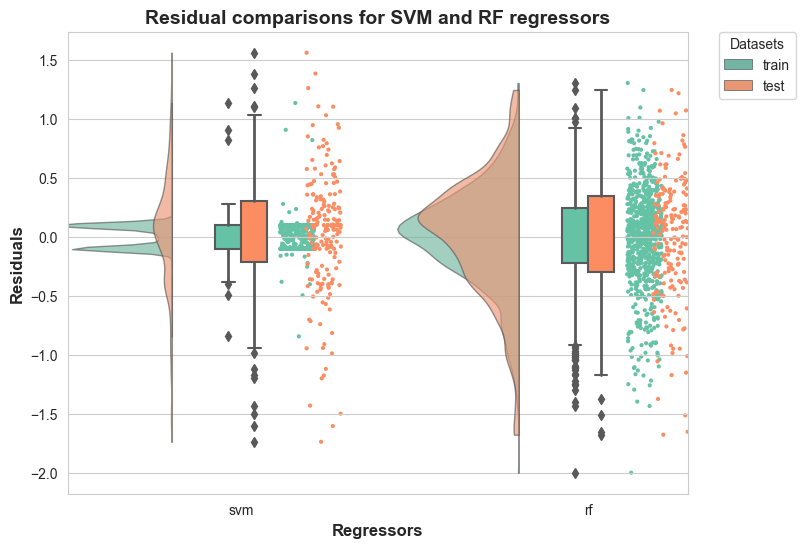

In [15]:
f, ax = plt.subplots(figsize=(8, 6))
ax = pt.RainCloud(
    x='Regressors',
    order=['svm', 'rf'],
    y='Residuals',
    hue='Datasets',
    hue_order=['train', 'test'],
    data=regressors_compare_df,
    palette='Set2',
    bw=0.2,
    width_viol=.7,
    ax=ax,
    orient='v',
    move=.2,
    alpha=0.65,
    dodge=True
)
ax.set_title('Residual comparisons for SVM and RF regressors',
             weight='bold', fontsize=14)
ax.set_xlabel('Regressors', fontsize=12, fontweight='bold')
ax.set_ylabel('Residuals', fontsize=12, fontweight='bold')
plt.savefig(
    r'model_outputs\model_comparisions\same_model_different_datasets.png',
    dpi=600,
    bbox_inches='tight'
)

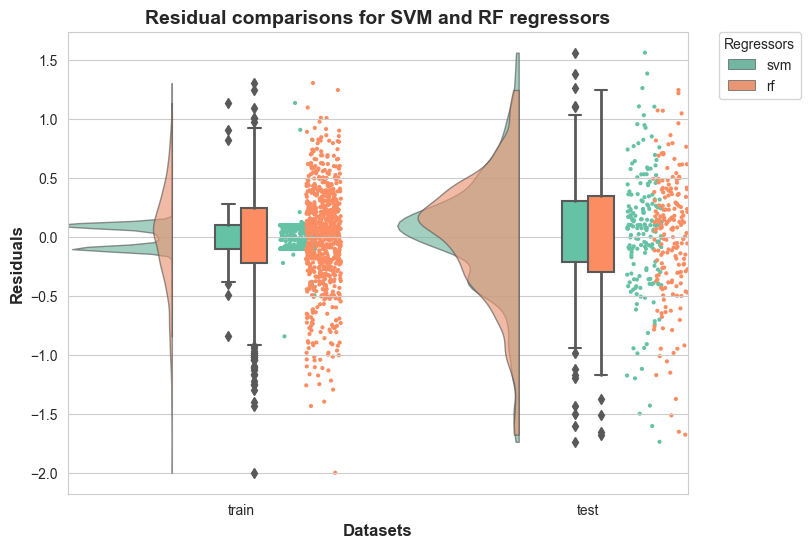

In [16]:
f, ax = plt.subplots(figsize=(8, 6))
ax = pt.RainCloud(
    x='Datasets',
    order=['train', 'test'],
    y='Residuals',
    hue='Regressors',
    hue_order=['svm', 'rf'],
    data=regressors_compare_df,
    palette='Set2',
    bw=0.2,
    width_viol=.7,
    ax=ax,
    orient='v',
    move=.2,
    alpha=0.65,
    dodge=True
)
ax.set_title('Residual comparisons for SVM and RF regressors',
             fontweight='bold', fontsize=14)
ax.set_xlabel('Datasets', fontweight='bold', fontsize=12)
ax.set_ylabel('Residuals', fontweight='bold', fontsize=12)
plt.savefig(
    r'model_outputs\model_comparisions\same_datasets_different_models.png',
    dpi=600,
    bbox_inches='tight'
)

# Classification

## Load pickles

In [36]:
centroid_svm = load_pickle(r'model_pickles\best_svm_classifier_centroid.pkl')

mlp_classifier = load_pickle(r'model_pickles\best_mlp_classifier.pkl')

X_classifier = load_pickle\
    (r'model_outputs\mlp_classifier\classification_X_test.pkl')
y_classifier = load_pickle\
    (r'model_outputs\mlp_classifier\classification_y_test.pkl')

## ROC curve

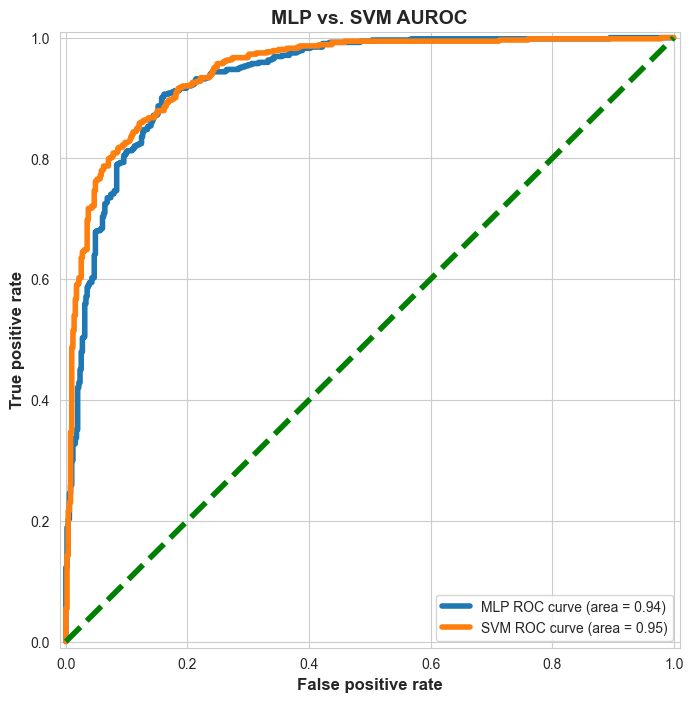

In [39]:
positive_label_index = 0
y_mlp_probabilities=mlp_classifier.predict_proba(X_classifier)[:, positive_label_index]
y_svm_probabilities=centroid_svm.predict_proba(X_classifier)[:, positive_label_index]

# Compute ROC curve and ROC area for each class
fpr_mlp, tpr_mlp, _ = roc_curve(y_classifier, y_mlp_probabilities,
                                pos_label='BBB+')
fpr_svm, tpr_svm, _ = roc_curve(y_classifier, y_svm_probabilities,
                                pos_label='BBB+')
roc_auc_mlp = auc(fpr_mlp, tpr_mlp)
roc_auc_svm = auc(fpr_svm, tpr_svm)

fig, ax = plt.subplots(figsize=(8, 8))

plt.plot(
    fpr_mlp,
    tpr_mlp,
    lw=4,
    label='MLP ROC curve (area = %0.2f)' % roc_auc_mlp
)
plt.plot(
    fpr_svm,
    tpr_svm,
    lw=4,
    label='SVM ROC curve (area = %0.2f)' % roc_auc_svm
)
plt.plot(
    [0, 1],
    [0, 1],
    color='green',
    lw=4,
    linestyle='--'
)

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False positive rate',weight='bold', fontsize=12)
plt.ylabel('True positive rate',weight='bold', fontsize=12)
plt.title('MLP vs. SVM AUROC',weight='bold', fontsize=14)
plt.legend(loc='lower right')

# plt.savefig(
#     r'model_outputs\mlp_classifier\auroc.png',
#     dpi=600,
#     bbox_inches='tight'
# )

plt.show()

## DeLong's test

In [20]:
centroid_probs = centroid_svm.predict_proba(X_classifier)

mlp_probs = mlp_classifier.predict_proba(X_classifier)

centroid_auc = roc_auc_score(y_classifier, centroid_probs[:, 1])

mlp_auc = roc_auc_score(y_classifier, mlp_probs[:, 1])

In [21]:
new_centroid_probs = centroid_probs[:,1]
new_mlp_probs = mlp_probs[:,1]

In [22]:
y_true = y_classifier.values
np.delete(y_true, 1)

for i in range(len(y_true)):
    if y_true[i] == 'BBB+':
        y_true[i] = 1
    else:
        y_true[i] = 0


In [23]:
delongs_test(new_centroid_probs, new_mlp_probs, centroid_auc, mlp_auc, y_classifier)

Model A's V10: [0.007782101167315175, 0.03696498054474708, 0.12840466926070038, 0.18093385214007782, 0.0, 0.10700389105058365, 0.011673151750972763, 0.0019455252918287938, 0.0038910505836575876, 0.0, 0.0038910505836575876, 0.01556420233463035, 0.0038910505836575876, 0.11089494163424124, 0.24124513618677043, 0.0, 0.03696498054474708, 0.017509727626459144, 0.04669260700389105, 0.007782101167315175, 0.0019455252918287938, 0.2607003891050584, 0.009727626459143969, 0.009727626459143969, 0.01556420233463035, 0.21595330739299612, 0.0038910505836575876, 0.048638132295719845, 0.017509727626459144, 0.0, 0.03696498054474708, 0.0019455252918287938, 0.009727626459143969, 0.011673151750972763, 0.0019455252918287938, 0.009727626459143969, 0.007782101167315175, 0.027237354085603113, 0.009727626459143969, 0.04669260700389105, 0.3638132295719844, 0.013618677042801557, 0.10311284046692606, 0.0, 0.0622568093385214, 0.03501945525291829, 0.017509727626459144, 0.017509727626459144, 0.03501945525291829, 0.110

0.06273982555854594

### Prep holdout data

In [18]:
# classification_holdout_df = pd.read_csv(
#     r'datasets\holdout_datasets\classification_df_expanded_cleaned_holdout.csv.zip'
# )
# classification_holdout_df

In [19]:
# classification_holdout_X = classification_holdout_df.drop(['SMILES', 'BBB+/BBB-'],axis=1)
#
# centroid_pipeline = load_pickle(
#     r'model_outputs\svm_classifier\centroid_pipeline.pkl'
# )
# X_processed = centroid_pipeline.transform(classification_holdout_X)
#
# classification_holdout_y = classification_holdout_df['BBB+/BBB-']
